In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.15.0
ipykernel        : 6.25.0
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.9.2
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


# Introduction

### What is Yu-Gi-Oh

### How dataset was obtained

### Motivation for data analysis, Problem Statement

Questions We Are Looking To Answer 
- Predict price of card (Linear Regressions) \[attk/level/defence/set\] 
- Predict level based on attack and defence 
- Predict "effect monster" Type \[categorical\] based (Classification Tree) 

Pointers <br>
Make a point on how data is cleaned 
Still do EDA, and see the exceptions 
AKA showcase you know your stuff 
Can split monsters based on can summon normally, or need sacrifice to find. 
 - Can become categorical (bucketing, similar to histograms) 
Show the trend of powercreep over the sets

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [3]:
data_file_location = 'card_data.csv'

yugioh_data = pd.read_csv(data_file_location,index_col=0)
yugioh_data.head(10) # quick look of data

,id,name,type,frameType,desc,race,archetype,card_sets,card_images,card_prices,atk,def,level,attribute,pend_desc,monster_desc,scale,linkval,linkmarkers,banlist_info
0,34541863,"""A"" Cell Breeding Device",Spell Card,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,"[{'set_name': 'Force of the Breaker', 'set_cod...","[{'id': 34541863, 'image_url': 'https://images...","[{'cardmarket_price': '0.10', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64163367,"""A"" Cell Incubator",Spell Card,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,"[{'set_name': ""Gladiator's Assault"", 'set_code...","[{'id': 64163367, 'image_url': 'https://images...","[{'cardmarket_price': '0.07', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91231901,"""A"" Cell Recombination Device",Spell Card,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,"[{'set_name': 'Invasion: Vengeance', 'set_code...","[{'id': 91231901, 'image_url': 'https://images...","[{'cardmarket_price': '0.10', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73262676,"""A"" Cell Scatter Burst",Spell Card,spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play,Alien,"[{'set_name': 'Strike of Neos', 'set_code': 'S...","[{'id': 73262676, 'image_url': 'https://images...","[{'cardmarket_price': '0.12', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98319530,"""Infernoble Arms - Almace""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': 'Duelist Nexus', 'set_code': 'DU...","[{'id': 98319530, 'image_url': 'https://images...","[{'cardmarket_price': '0.00', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,37478723,"""Infernoble Arms - Durendal""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 37478723, 'image_url': 'https://images...","[{'cardmarket_price': '0.16', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,64867422,"""Infernoble Arms - Hauteclere""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 64867422, 'image_url': 'https://images...","[{'cardmarket_price': '0.02', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,90861137,"""Infernoble Arms - Joyeuse""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 90861137, 'image_url': 'https://images...","[{'cardmarket_price': '0.18', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,80845034,"""The Sinful Spoils Hunter Fiend""",Spell Card,spell,"Add 1 ""Diabellestarr"" monster from your Deck o...",Quick-Play,Sinful Spoils,NaN,"[{'id': 80845034, 'image_url': 'https://images...","[{'cardmarket_price': '0.00', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,44256816,1st Movement Solo,Spell Card,spell,If you control no monsters: Special Summon 1 L...,Normal,Melodious,"[{'set_name': '2015 Mega-Tin Mega Pack', 'set_...","[{'id': 44256816, 'image_url': 'https://images...","[{'cardmarket_price': '2.85', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis [EDA]

In [4]:
# Information about the Variables
yugioh_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12815 entries, 0 to 12814
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            12815 non-null  int64  
 1   name          12815 non-null  object 
 2   type          12815 non-null  object 
 3   frameType     12815 non-null  object 
 4   desc          12815 non-null  object 
 5   race          12814 non-null  object 
 6   archetype     7443 non-null   object 
 7   card_sets     12374 non-null  object 
 8   card_images   12815 non-null  object 
 9   card_prices   12815 non-null  object 
 10  atk           8331 non-null   float64
 11  def           7943 non-null   float64
 12  level         7942 non-null   float64
 13  attribute     8331 non-null   object 
 14  pend_desc     322 non-null    object 
 15  monster_desc  322 non-null    object 
 16  scale         337 non-null    float64
 17  linkval       388 non-null    float64
 18  linkmarkers   388 non-null    o

<b> Listing down observations of dataset: </b>

- 20 columns and 12815 rows.
- 1 variables identified as int64 by default, and it seems is indeed Numeric.
- 5 variables identified as float64 by default, and it seems are indeed Numeric.
- 14 variables identified as object by default, 
    - 4 variables are Strings, which represent card text and should not be used for Categorical values.
        - (name, desc, pend_desc, monster_desc)
    - 1 variables is a JSON object, which represent link data to card images and should not be used for Categorical values.
        - (card_images)
    - 3 variables are JSON objects, which represent Categorical values.
        - (card_sets, linkmarkers, banlist_info)
    - 5 variables are Strings, which represent Categorical values.
        - (type, frameType, race, archetype, attribute)
    - 1 variables is a JSON object, which represent multiple Numeric values.
        - (card_prices)


<b> Cleaning actions to be taken </b> <br>
    - Extract out values from relevant JSON objects (card_prices)
    
None of the variables/features seem to have any missing value (have to check again, carefully).
- card_prices is 


### Drop irrelevant columns about descriptions

In [5]:
### Read from csv and Drop irrelevant columns about descriptions
yugioh_data = pd.read_csv(data_file_location,index_col=0)
yugioh_data = yugioh_data.drop(['desc','pend_desc','card_images','monster_desc','linkval','pend_desc','scale','linkmarkers'], axis=1)

### Drop non-monsters from dataset

In [6]:
# Visulising unique types for categorical values
unique_types = yugioh_data['type'].unique()
print(unique_types)

['Spell Card' 'Effect Monster' 'Normal Monster' 'Flip Effect Monster'
 'Trap Card' 'Union Effect Monster' 'Fusion Monster'
 'Pendulum Effect Monster' 'Link Monster' 'XYZ Monster' 'Synchro Monster'
 'Synchro Tuner Monster' 'Tuner Monster' 'Gemini Monster'
 'Normal Tuner Monster' 'Spirit Monster' 'Ritual Effect Monster'
 'Skill Card' 'Token' 'Pendulum Effect Fusion Monster' 'Ritual Monster'
 'Toon Monster' 'Pendulum Normal Monster'
 'Synchro Pendulum Effect Monster' 'Pendulum Tuner Effect Monster'
 'XYZ Pendulum Effect Monster' 'Pendulum Effect Ritual Monster'
 'Pendulum Flip Effect Monster']


In [7]:
# Remove non-monsters from dataset.
yugioh_data = yugioh_data[~yugioh_data['type'].isin(['Skill Card', 'Spell Card', 'Trap Card', 'Token'])]
yugioh_data.head()

,id,name,type,frameType,race,archetype,card_sets,card_prices,atk,def,level,attribute,banlist_info
10,86988864,3-Hump Lacooda,Effect Monster,effect,Beast,NaN,"[{'set_name': 'Ancient Sanctuary', 'set_code':...","[{'cardmarket_price': '0.16', 'tcgplayer_price...",500.0,1500.0,3.0,EARTH,NaN
11,11714098,"30,000-Year White Turtle",Normal Monster,normal,Aqua,NaN,NaN,"[{'cardmarket_price': '0.00', 'tcgplayer_price...",1250.0,2100.0,5.0,WATER,NaN
12,83994646,4-Starred Ladybug of Doom,Flip Effect Monster,effect,Insect,NaN,"[{'set_name': 'Dark Beginning 1', 'set_code': ...","[{'cardmarket_price': '0.12', 'tcgplayer_price...",800.0,1200.0,3.0,WIND,NaN
14,23771716,7 Colored Fish,Normal Monster,normal,Fish,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","[{'cardmarket_price': '0.06', 'tcgplayer_price...",1800.0,800.0,4.0,WATER,NaN
16,14261867,8-Claws Scorpion,Effect Monster,effect,Insect,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","[{'cardmarket_price': '0.11', 'tcgplayer_price...",300.0,200.0,2.0,DARK,NaN


### Extract price data into 5 individual price columns from original JSON data

In [8]:
import json

# Strip the starting and ending '[]' from column
yugioh_data['card_prices'] = yugioh_data['card_prices'].str.strip('[]')

# Convert the string in the 'card_prices' column to a dictionary
yugioh_data['card_prices'] = yugioh_data['card_prices'].apply(lambda x: json.loads(x.replace("'", '"')))

# Normalize the 'card_prices' column to create separate columns for each key in the dictionary
kekw = pd.json_normalize(yugioh_data['card_prices']).set_index(yugioh_data.index)
yugioh_data = pd.concat([yugioh_data, kekw], axis=1)

# Prices are currently of type string, convert price_columns to float64
price_columns = ['cardmarket_price', 'tcgplayer_price', 'ebay_price', 'amazon_price', 'coolstuffinc_price']
yugioh_data[price_columns] = yugioh_data[price_columns].apply(pd.to_numeric)

# Now the DataFrame 'yugioh_data' contains 5 new columns with the prices from the 'card_prices' column as float64
#yugioh_data[price_columns].head()
#yugioh_data[price_columns].info()

# Reset index of dataframe to be sequential
yugioh_data = yugioh_data.reset_index(drop=False)

### Create a new column ['avg_price'], which is the mean price, ignoring null values

In [9]:
# Set 0.00 price to NaN
yugioh_data[price_columns] = yugioh_data[price_columns].replace(0.00, np.NaN)

# Calculate mean price into ['avg_price']
yugioh_data['avg_price'] = yugioh_data[price_columns].mean(axis=1, skipna=True)

# Set Nan to 0.00 price 
yugioh_data[price_columns] = yugioh_data[price_columns].replace(np.NaN, 0.00)

# Dataframe displayed
price_columns.append("avg_price")
yugioh_data[price_columns].head()

,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price
0,0.16,0.16,1.00,0.25,0.25,0.364
1,0.00,0.00,10.00,0.50,0.00,5.250
2,0.12,0.05,0.99,0.99,0.25,0.480
3,0.06,0.16,1.99,2.77,0.39,1.074
4,0.11,0.22,0.99,0.20,0.25,0.354


### Reduce skew of 'cardmarket_price'
#### Remove rows with outlier price value for CardMarket price
- Remove prices above 100 Dollars
- Remove prices of 0 Dollars (not listed on cardmarket)

In [10]:
# Remove rows with prices that are missing or above 100.
cardmarketRange = (yugioh_data['cardmarket_price'] > 0.00) & (yugioh_data['cardmarket_price'] < 100)
tcgplayerRange = (yugioh_data['tcgplayer_price'] > 0.00) & (yugioh_data['tcgplayer_price'] < 100)
ebayRange = (yugioh_data['ebay_price'] > 0.00) & (yugioh_data['ebay_price'] < 100)
amazonRange = (yugioh_data['amazon_price'] > 0.00) & (yugioh_data['amazon_price'] < 100)
coolstuffincRange = (yugioh_data['coolstuffinc_price'] > 0.00) & (yugioh_data['coolstuffinc_price'] < 100)

yugioh_data = yugioh_data[cardmarketRange & tcgplayerRange & ebayRange & amazonRange & coolstuffincRange]

yugioh_data[price_columns].describe()


,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price
count,7390.000000,7390.000000,7390.000000,7390.000000,7390.000000,7390.000000
mean,0.759472,0.701599,3.153666,3.436419,1.079426,1.826117
std,2.379155,2.310888,5.984756,8.946884,2.523478,3.165519
min,0.020000,0.010000,0.010000,0.010000,0.250000,0.132000
25%,0.090000,0.140000,0.990000,0.250000,0.250000,0.466500
50%,0.160000,0.210000,1.490000,0.990000,0.490000,0.780000
75%,0.380000,0.440000,2.990000,2.357500,0.990000,1.663500
max,47.980000,61.700000,99.000000,99.990000,69.990000,57.132000


<Axes: >

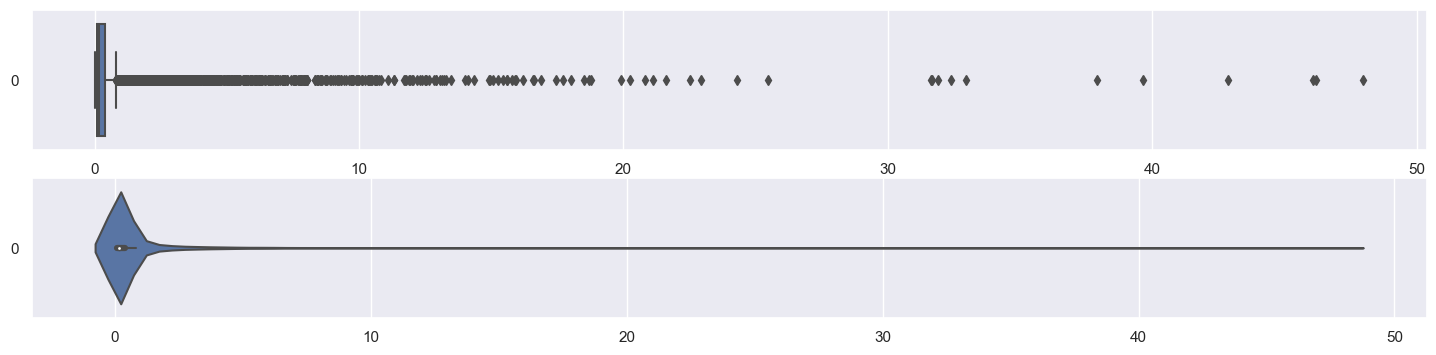

In [11]:
# boxplot and violin plot of cardmarket_price after removal of empty values and values above 100
f, axes = plt.subplots(2, 1, figsize=(18, 4))
sb.boxplot(data = yugioh_data['cardmarket_price'], orient = "h", ax = axes[0])
sb.violinplot(data = yugioh_data['cardmarket_price'], orient = "h", ax = axes[1])

### Using logarithm to combat skew

In [12]:
### 2 Methods to prepare data for Logarithm
# Increment values by 1
#yugioh_data["cardmarket_price"] = yugioh_data["cardmarket_price"] + 1
#yugioh_data['cardmarket_price'].describe()

# Convert data to integer values by * 100
#yugioh_data["cardmarket_price"] = yugioh_data["cardmarket_price"] * 100
#yugioh_data['cardmarket_price'].describe()

#Apply a logarithmic transformation to the data
#yugioh_data['cardmarket_price'] = np.log(yugioh_data["cardmarket_price"]) 

# Display plots after logaritmic skew management
#f, axes = plt.subplots(2, 1, figsize=(18, 4))
#sb.boxplot(data = yugioh_data['cardmarket_price'], orient = "h", ax = axes[0])
#sb.violinplot(data = yugioh_data['cardmarket_price'], orient = "h", ax = axes[1])

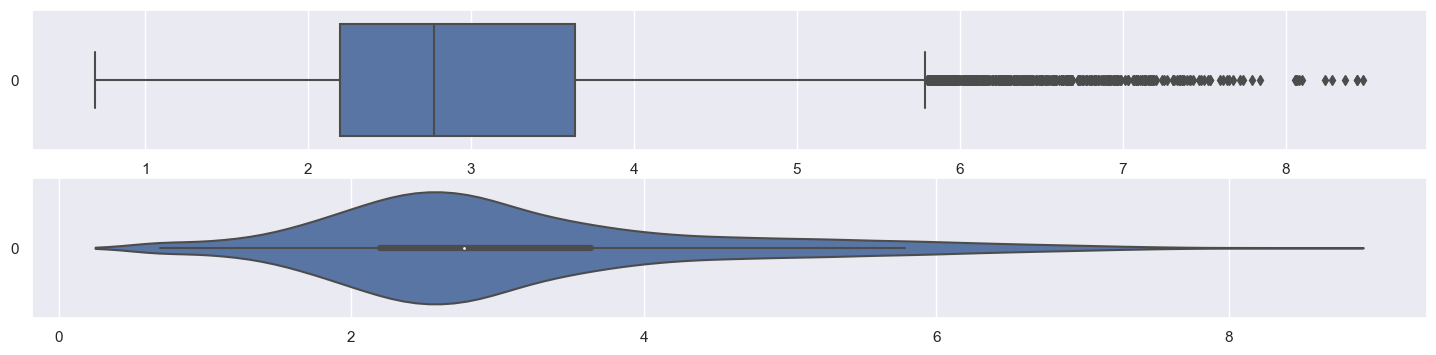

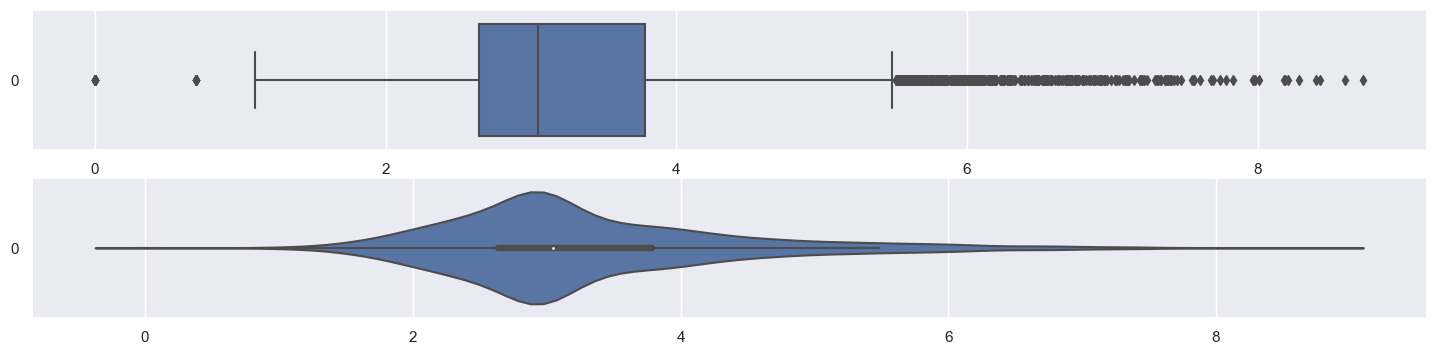

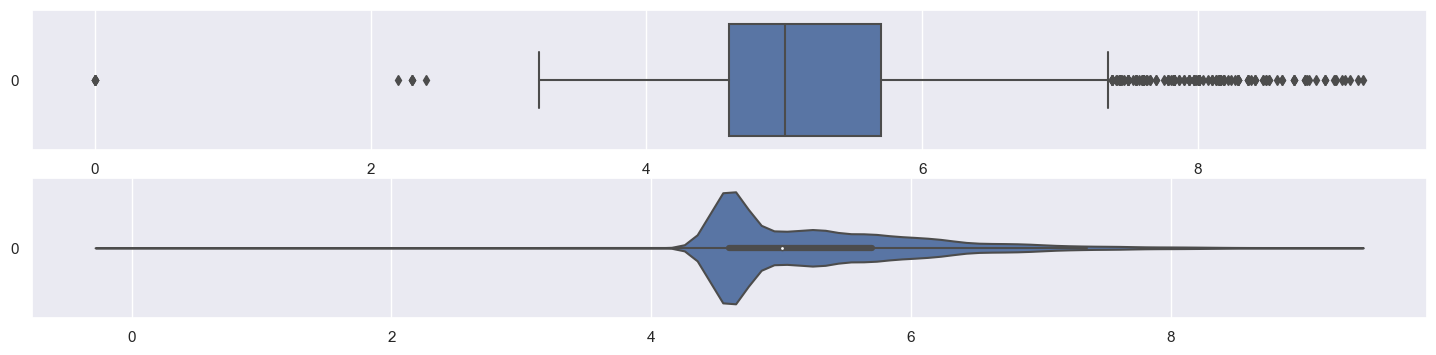

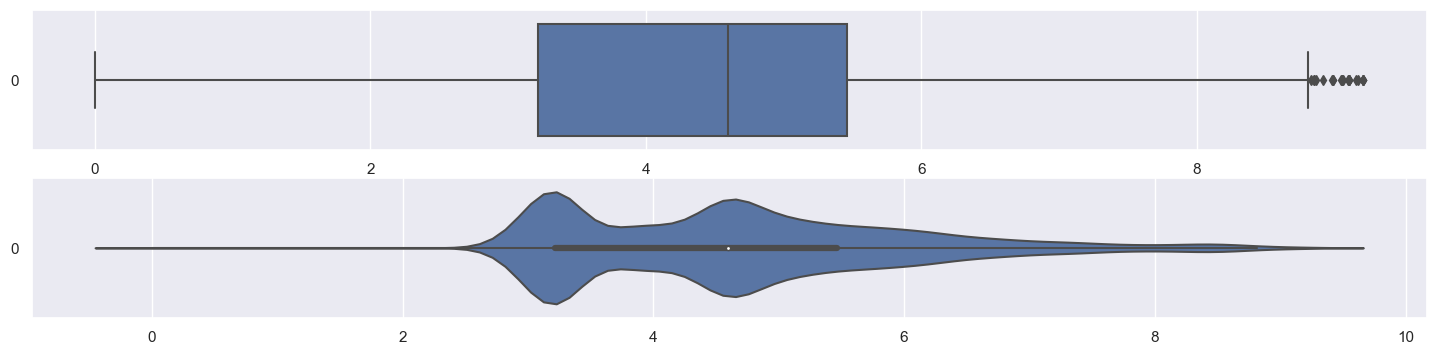

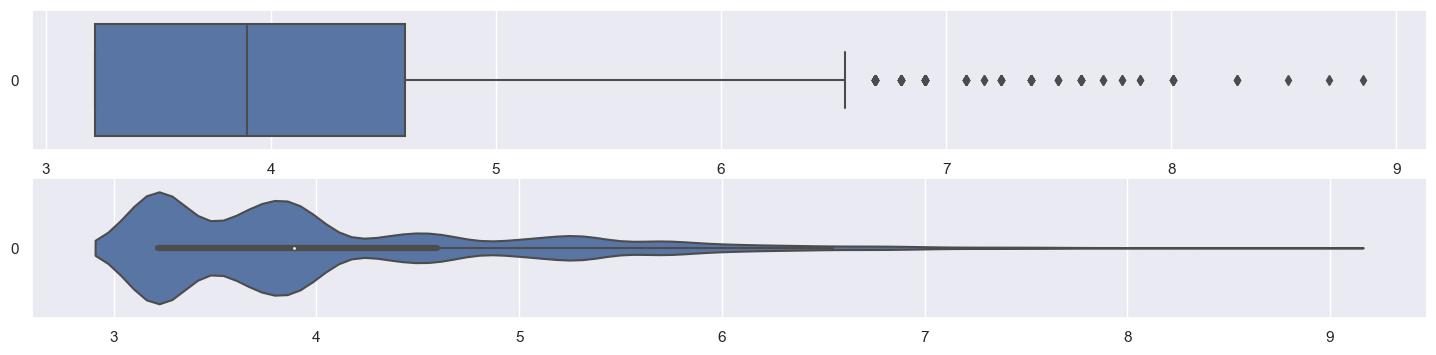

In [13]:
price_columns = ['cardmarket_price', 'tcgplayer_price', 'ebay_price', 'amazon_price', 'coolstuffinc_price']
for var in price_columns:
    # Convert data to integer values by * 100
    yugioh_data[var] = yugioh_data[var] * 100
    yugioh_data[var].describe()

    #Apply a logarithmic transformation to the data
    yugioh_data[var] = np.log(yugioh_data[var]) 
    
    f, axes = plt.subplots(2, 1, figsize=(18, 4))
    sb.boxplot(data = yugioh_data[var], orient = "h", ax = axes[0])
    sb.violinplot(data = yugioh_data[var], orient = "h", ax = axes[1])


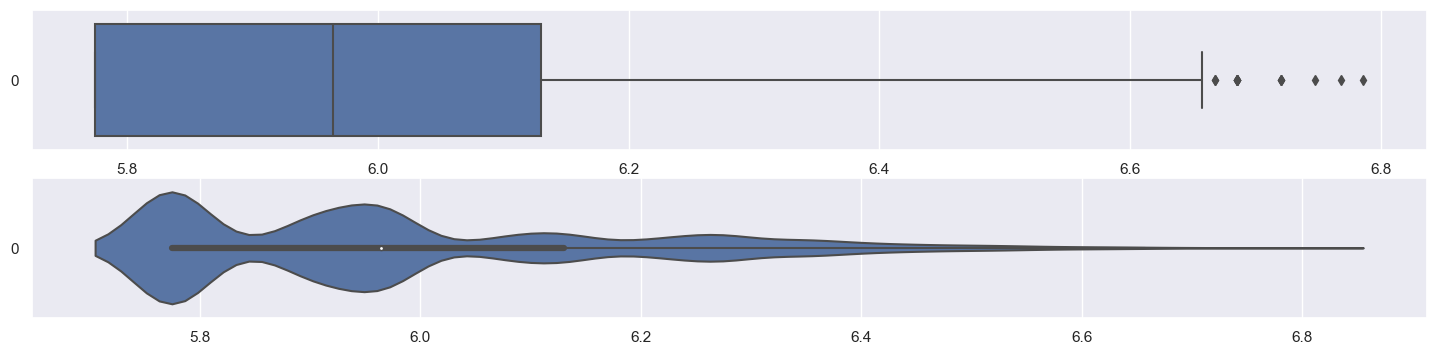

In [14]:
price_columns = ['coolstuffinc_price']
for var in price_columns:
    # Convert data to integer values by * 100
    yugioh_data[var] = yugioh_data[var] * 100
    yugioh_data[var].describe()

    #Apply a logarithmic transformation to the data
    yugioh_data[var] = np.log(yugioh_data[var]) 
    
    f, axes = plt.subplots(2, 1, figsize=(18, 4))
    sb.boxplot(data = yugioh_data[var], orient = "h", ax = axes[0])
    sb.violinplot(data = yugioh_data[var], orient = "h", ax = axes[1])


### Separate "Level" into level ranges and bins
- Level 1 to 4 => 0 tribute
- Level 5 to 6 => 1 tribute
- Level 7 to inf => 2 tribute

In [15]:
# Define the bins for the level ranges
bins = [0.5, 4.0, 6.0, float('inf')]  

# Define the labels for the level ranges
labels = ['0', '1', '2']

# Create a new column 'tribute' to store the bucketed groups
yugioh_data['tribute'] = pd.cut(yugioh_data['level'], bins=bins, labels=labels, right=True)
# If right==True (the default), then the bins [1.0, 4.0, 7.0, float('inf')] indicate (0.5,4.0], (4.0,6], (6,inf].
# If right==False, bins will be the inbetween values, (1,2), (2,3), (3,4).

tribute0 = yugioh_data[yugioh_data['level'].between(0.5, 4.5)]
tribute1 = yugioh_data[yugioh_data['level'].between(4.5, 6.5)]
tribute2 = yugioh_data[yugioh_data['level'] >= 7]

# Display the new column
yugioh_data[['name','level','tribute']].head(10)

,name,level,tribute
0,3-Hump Lacooda,3.0,0
2,4-Starred Ladybug of Doom,3.0,0
3,7 Colored Fish,4.0,0
4,8-Claws Scorpion,2.0,0
5,A Cat of Ill Omen,2.0,0
6,A Man with Wdjat,4.0,0
7,A-Assault Core,4.0,0
8,A-Team: Trap Disposal Unit,2.0,0
9,A-to-Z-Dragon Buster Cannon,10.0,2
10,A/D Changer,1.0,0


# EDA OF NUMERIC VALUES


### Generating Additional Numerical Columns

In [16]:
# Generate New Numerical Columns
yugioh_data['atk+def'] = yugioh_data.loc[:,['atk','def']].sum(axis=1)
yugioh_data['atkSq'] = yugioh_data['atk'] * yugioh_data['atk']
yugioh_data['defSq'] = yugioh_data['def'] * yugioh_data['def']
yugioh_data['atkSq+defSq'] = yugioh_data['atkSq'] + yugioh_data['defSq']

# Describe all numerical columns present now
price_columns = ['cardmarket_price', 'tcgplayer_price', 'ebay_price', 'amazon_price', 'coolstuffinc_price', 'avg_price']
numericalColumns = ['atk', 'def', 'level']
newNumericalColumns = ['atk+def', 'atkSq', 'defSq', 'atkSq+defSq']

numericalColumns.extend(price_columns)
numericalColumns.extend(newNumericalColumns)

In [17]:
# Extract numeric data variables
yugioh_numerical_data = pd.DataFrame(yugioh_data[numericalColumns])

# Summary Statistics for all Variables
yugioh_numerical_data.describe().round(2)

,atk,def,level,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,atk+def,atkSq,defSq,atkSq+defSq
count,7390.00,7043.00,7043.00,7390.00,7390.00,7390.00,7390.00,7390.00,7390.00,7390.00,7390.00,7043.00,7043.00
mean,1482.03,1250.44,4.57,3.08,3.28,5.25,4.68,5.98,1.83,2673.75,3074988.54,2304392.66,5356814.26
std,937.39,860.75,2.35,1.32,1.11,0.84,1.34,0.21,3.17,1535.55,3165288.54,2636462.92,5132441.34
min,0.00,0.00,0.00,0.69,0.00,0.00,0.00,5.77,0.13,0.00,0.00,0.00,0.00
25%,800.00,600.00,3.00,2.20,2.64,4.60,3.22,5.77,0.47,1700.00,640000.00,360000.00,2000000.00
50%,1500.00,1200.00,4.00,2.77,3.04,5.00,4.60,5.96,0.78,2600.00,2250000.00,1440000.00,4000000.00
75%,2100.00,1900.00,6.00,3.64,3.78,5.70,5.46,6.13,1.66,3600.00,4410000.00,3610000.00,7322500.00
max,5000.00,5000.00,13.00,8.48,8.73,9.20,9.21,6.79,57.13,10000.00,25000000.00,25000000.00,50000000.00


In [18]:
yugioh_data[numericalColumns].head()

,atk,def,level,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,atk+def,atkSq,defSq,atkSq+defSq
0,500.0,1500.0,3.0,2.772589,2.772589,4.605170,3.218876,5.774202,0.364,2000.0,250000.0,2250000.0,2500000.0
2,800.0,1200.0,3.0,2.484907,1.609438,4.595120,4.595120,5.774202,0.480,2000.0,640000.0,1440000.0,2080000.0
3,1800.0,800.0,4.0,1.791759,2.772589,5.293305,5.624018,5.903606,1.074,2600.0,3240000.0,640000.0,3880000.0
4,300.0,200.0,2.0,2.397895,3.091042,4.595120,2.995732,5.774202,0.354,500.0,90000.0,40000.0,130000.0
5,500.0,300.0,2.0,4.234107,5.170484,5.988961,6.107023,6.130165,2.384,800.0,250000.0,90000.0,340000.0


In [19]:
# Draw the distributions of all variables len(numericalColumns)
#f, axes = plt.subplots(len(numericalColumns), 3, figsize=(18, 24))
#
#yugioh_numerical_data = yugioh_numerical_data.reset_index(drop=True)
#
#count = 0
#for var in yugioh_numerical_data:
#    sb.boxplot(data = yugioh_numerical_data[var], orient = "h", ax = axes[count,0])
#    sb.histplot(data = yugioh_numerical_data[var], ax = axes[count,1])
#    sb.violinplot(data = yugioh_numerical_data[var], orient = "h", ax = axes[count,2])
#    count += 1

'# Draw the distributions of all variables len(numericalColumns)\nf, axes = plt.subplots(len(numericalColumns), 3, figsize=(18, 24))\n\nyugioh_numerical_data = yugioh_numerical_data.reset_index(drop=True)\n\ncount = 0\nfor var in yugioh_numerical_data:\n    sb.boxplot(data = yugioh_numerical_data[var], orient = "h", ax = axes[count,0])\n    sb.histplot(data = yugioh_numerical_data[var], ax = axes[count,1])\n    sb.violinplot(data = yugioh_numerical_data[var], orient = "h", ax = axes[count,2])\n    count += 1'

### Correlation Matrix of Numerical Variables

<Axes: >

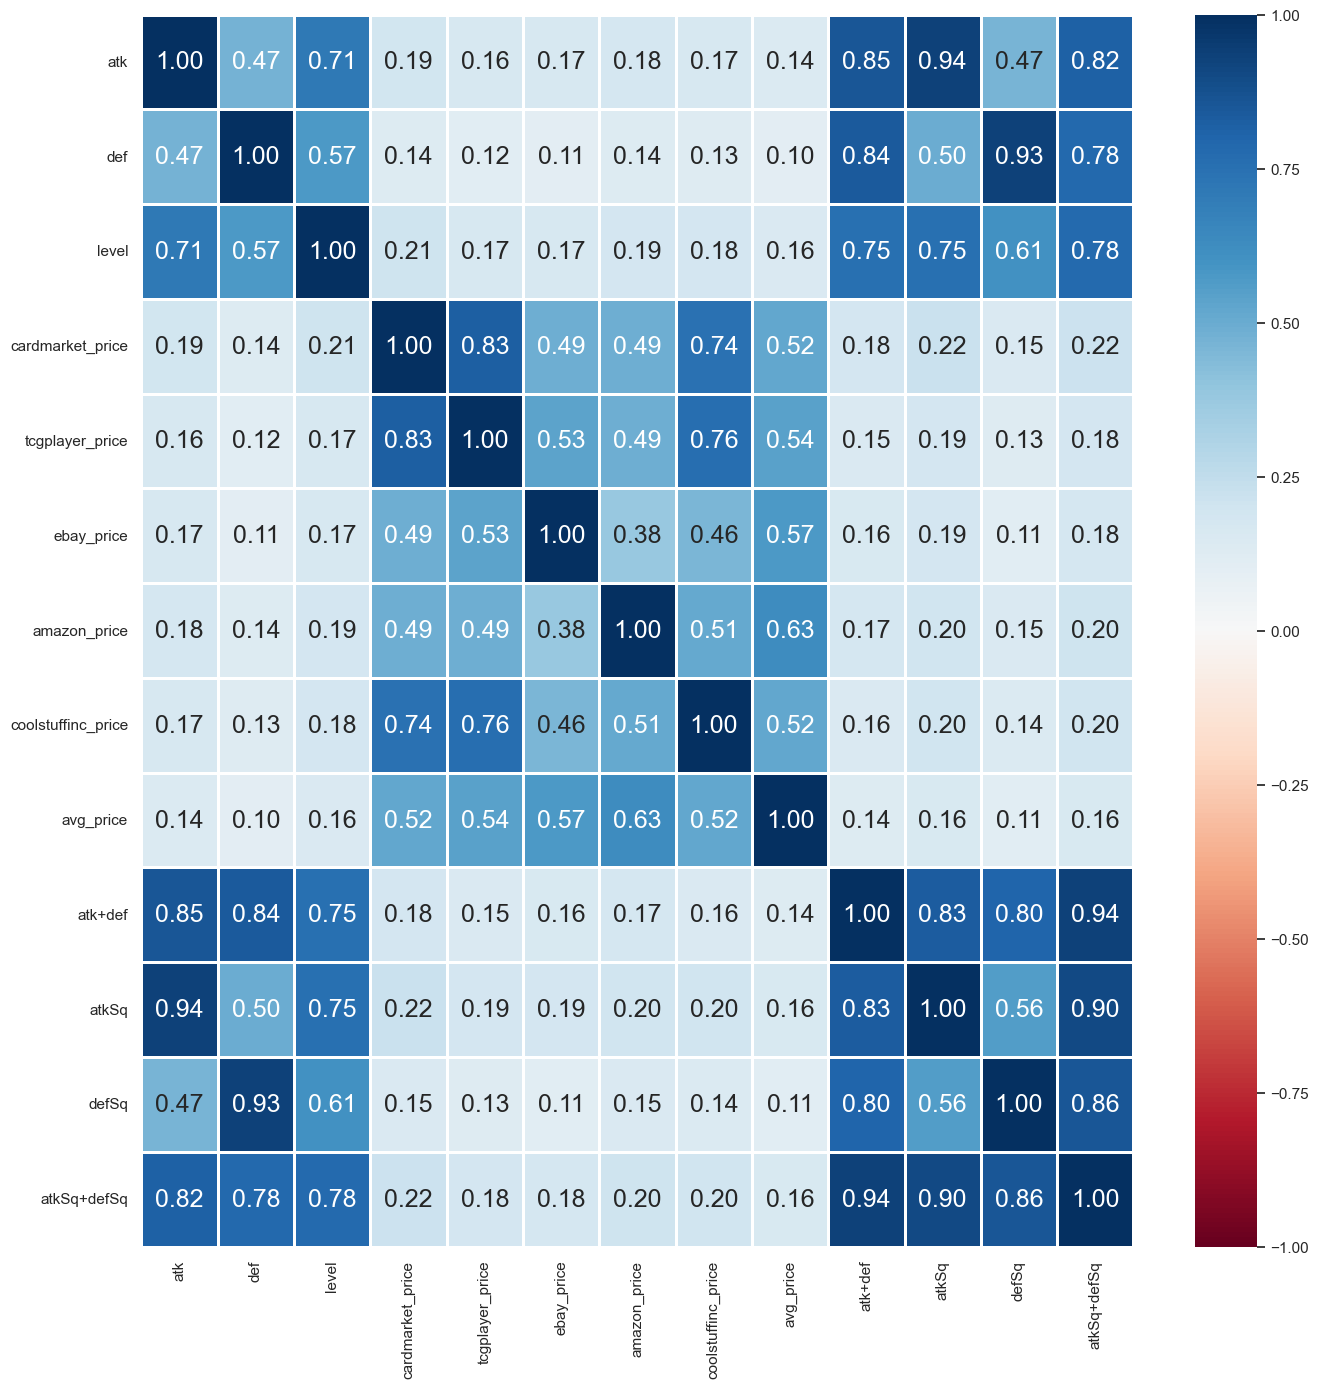

In [20]:
# Correlation Matrix
#print(yugioh_numerical_data.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(16, 16))
sb.heatmap(yugioh_numerical_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

### Realisation for linear regression / Analysis of correlation matrix
Despite measures taken to 

In [21]:
yugioh_numerical_data.head()

,atk,def,level,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,atk+def,atkSq,defSq,atkSq+defSq
0,500.0,1500.0,3.0,2.772589,2.772589,4.605170,3.218876,5.774202,0.364,2000.0,250000.0,2250000.0,2500000.0
2,800.0,1200.0,3.0,2.484907,1.609438,4.595120,4.595120,5.774202,0.480,2000.0,640000.0,1440000.0,2080000.0
3,1800.0,800.0,4.0,1.791759,2.772589,5.293305,5.624018,5.903606,1.074,2600.0,3240000.0,640000.0,3880000.0
4,300.0,200.0,2.0,2.397895,3.091042,4.595120,2.995732,5.774202,0.354,500.0,90000.0,40000.0,130000.0
5,500.0,300.0,2.0,4.234107,5.170484,5.988961,6.107023,6.130165,2.384,800.0,250000.0,90000.0,340000.0


In [22]:
yugioh_data.head()

,index,id,name,type,frameType,race,archetype,card_sets,card_prices,atk,...,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,tribute,atk+def,atkSq,defSq,atkSq+defSq
0,10,86988864,3-Hump Lacooda,Effect Monster,effect,Beast,NaN,"[{'set_name': 'Ancient Sanctuary', 'set_code':...","{'cardmarket_price': '0.16', 'tcgplayer_price'...",500.0,...,2.772589,4.605170,3.218876,5.774202,0.364,0,2000.0,250000.0,2250000.0,2500000.0
2,12,83994646,4-Starred Ladybug of Doom,Flip Effect Monster,effect,Insect,NaN,"[{'set_name': 'Dark Beginning 1', 'set_code': ...","{'cardmarket_price': '0.12', 'tcgplayer_price'...",800.0,...,1.609438,4.595120,4.595120,5.774202,0.480,0,2000.0,640000.0,1440000.0,2080000.0
3,14,23771716,7 Colored Fish,Normal Monster,normal,Fish,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","{'cardmarket_price': '0.06', 'tcgplayer_price'...",1800.0,...,2.772589,5.293305,5.624018,5.903606,1.074,0,2600.0,3240000.0,640000.0,3880000.0
4,16,14261867,8-Claws Scorpion,Effect Monster,effect,Insect,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","{'cardmarket_price': '0.11', 'tcgplayer_price'...",300.0,...,3.091042,4.595120,2.995732,5.774202,0.354,0,500.0,90000.0,40000.0,130000.0
5,17,24140059,A Cat of Ill Omen,Flip Effect Monster,effect,Beast,NaN,"[{'set_name': 'Dark Revelation Volume 1', 'set...","{'cardmarket_price': '0.69', 'tcgplayer_price'...",500.0,...,5.170484,5.988961,6.107023,6.130165,2.384,0,800.0,250000.0,90000.0,340000.0


In [23]:
#yugioh_data_normalMonsters = yugioh_data[yugioh_data['type'].isin(['Normal Monster'])]

# Extract numeric data variables
#yugioh_numerical_data = pd.DataFrame(yugioh_data[numericalColumns])

yugioh_numerical_data_normalMonsters = yugioh_data.loc[yugioh_data['type'] == "Synchro Monster", numericalColumns]


#yugioh_data_effectMonsters = yugioh_data[yugioh_data['type'].isin(['Effect Monster'])]

yugioh_numerical_data_effectMonsters = yugioh_data.loc[yugioh_data['type'] == "Pendulum Effect Monster", numericalColumns]

<Axes: >

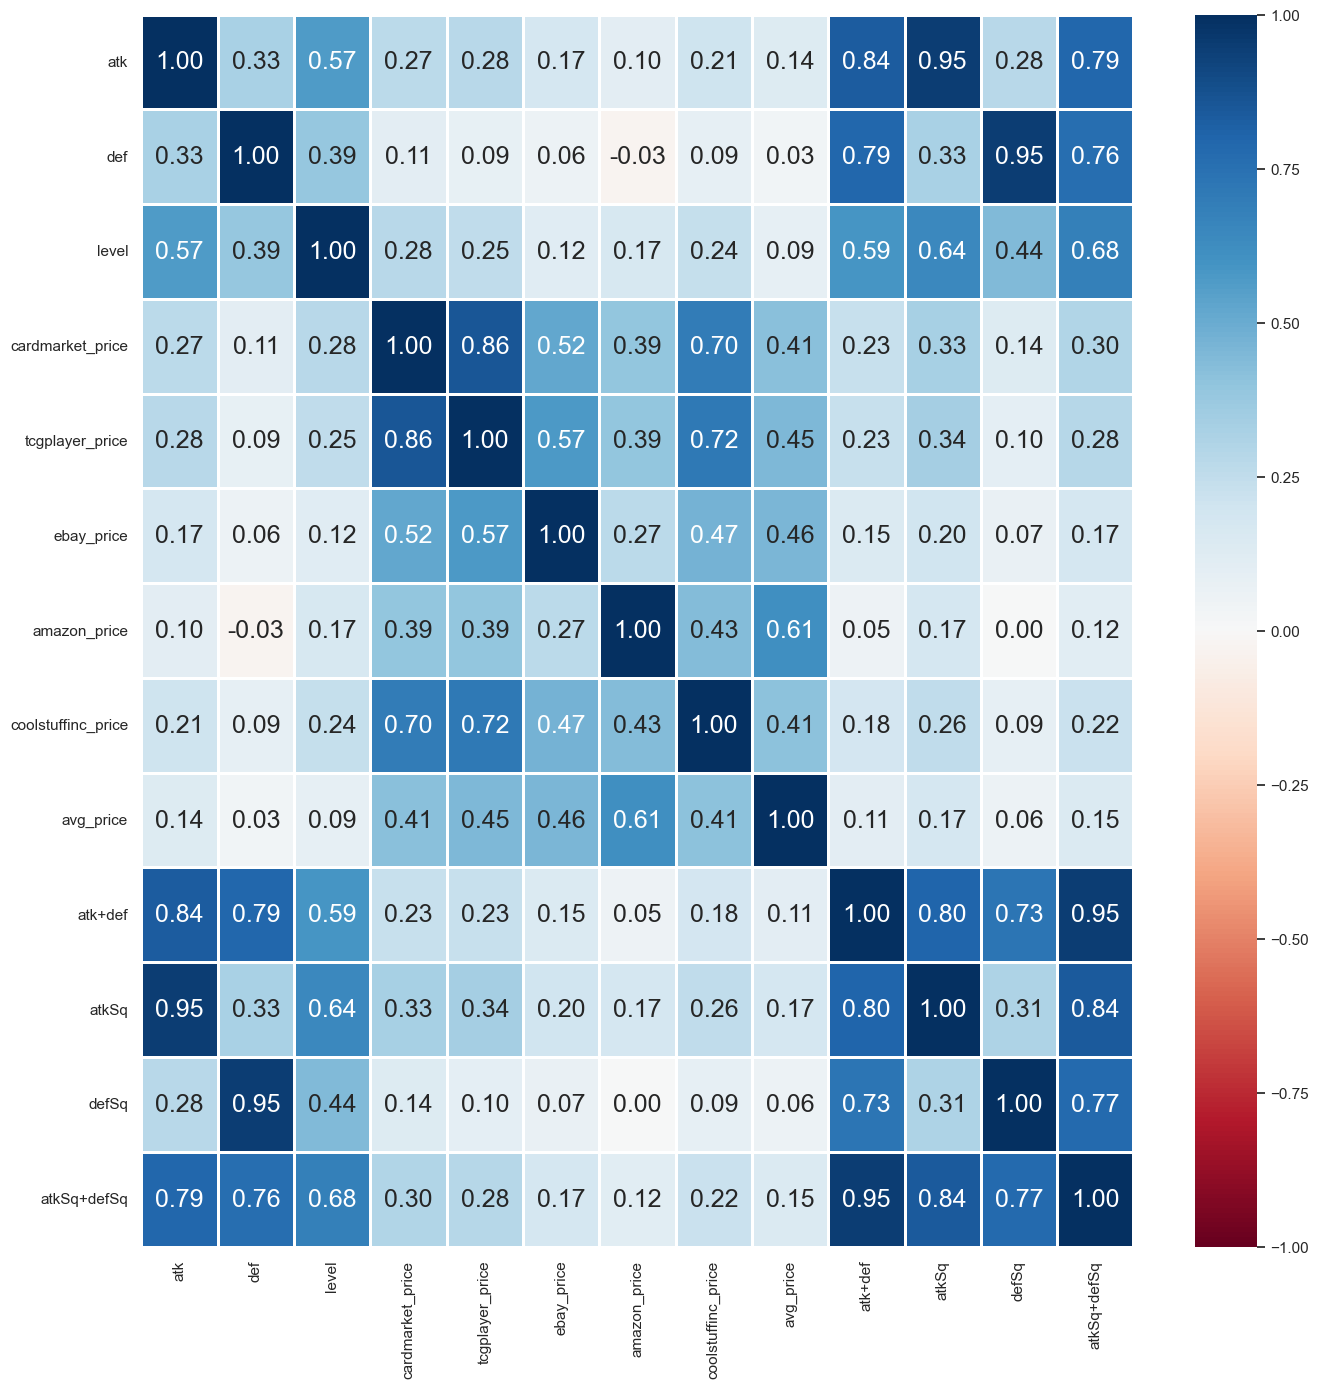

In [24]:
# Correlation Matrix
#print(yugioh_numerical_data.corr())

#yugioh_numerical_data_effectMonsters = yugioh_numerical_data[]

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(16, 16))
sb.heatmap(yugioh_numerical_data_effectMonsters.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

<Axes: >

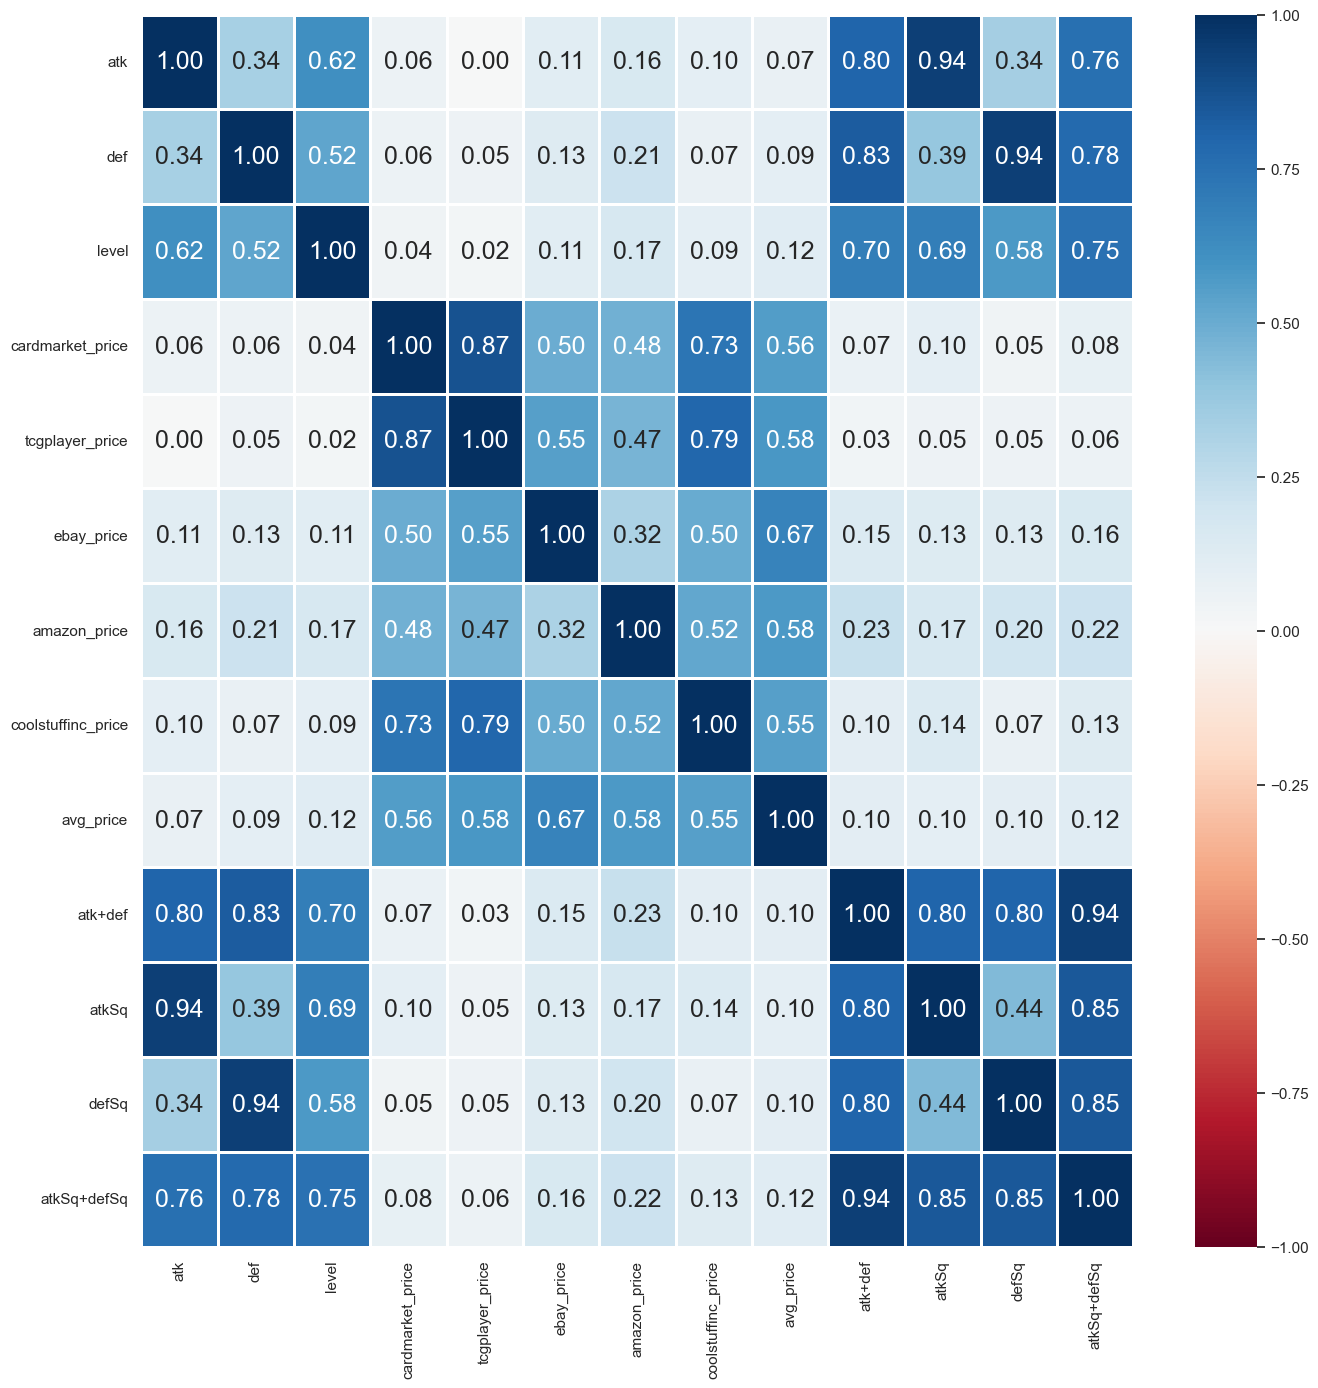

In [25]:
# Correlation Matrix
#print(yugioh_numerical_data.corr())

#yugioh_numerical_data_normalMonsters = yugioh_numerical_data[]

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(16, 16))
sb.heatmap(yugioh_numerical_data_normalMonsters.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

# Linear Regresstion of Numerical Values

### Analysis of correlation coefficients
The columns with good correlation to `level` so far are `atk` `def` `atkSq` `defSq` `atkSq + defSq`.
Interestingly, the higest correlation to level, is actually `atkSq + defSq`. 
Which is better than both atk or def taken separately.
As the squares of the values have higher correlation than the values themselves, 
This suggests that higher absolute value of atk and def have a greater impact in prediciting level than just atk or def itself.

In [23]:
predictors = ["atk", "def", "atkSq", "defSq", "atkSq+defSq"]
predictors.append("name")
pd.DataFrame(yugioh_data[predictors]).head()

,atk,def,atkSq,defSq,atkSq+defSq,name
0,500.0,1500.0,250000.0,2250000.0,2500000.0,3-Hump Lacooda
2,800.0,1200.0,640000.0,1440000.0,2080000.0,4-Starred Ladybug of Doom
3,1800.0,800.0,3240000.0,640000.0,3880000.0,7 Colored Fish
4,300.0,200.0,90000.0,40000.0,130000.0,8-Claws Scorpion
5,500.0,300.0,250000.0,90000.0,340000.0,A Cat of Ill Omen


### Handling NaN values for def
Link monster have NaN value for defence, for regression purposes we'll set their defence as 0

In [24]:
# Set NaN defence to 0.0
yugioh_data[predictors] = yugioh_data[predictors].replace(np.NaN, 0.00)


### Handling NaN values for level
Link monsters have NaN values for levels, for regression purposes we'll set their level as 0

In [25]:
yugioh_data[["level"]] = yugioh_data[["level"]].replace(np.NaN, 0.00)

#yugioh_data[["level","name"]][yugioh_data[["level","name"]].isnull().any(axis=1)]

In [26]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dataset
dataset = yugioh_numerical_data_effectMonsters

# Extract Response and Predictors
predictors = ["atkSq", "atkSq+defSq"]
reponse_variable = ["cardmarket_price"]

X = pd.DataFrame(dataset[predictors])
y = pd.DataFrame(dataset[reponse_variable])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape)
print(y_train.shape)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the training data and regression line.
#f = plt.figure(figsize=(16, 8))
#plt.scatter(X_train, y_train, color = "green")
##plt.scatter(X_test, y_test_pred, color = "red")
#plt.axline((0, linreg.intercept_.item()), slope=linreg.coef_.item(), label='by slope', linewidth=4, color='r')
#plt.show()

# Plot the test data and regression line.
#f = plt.figure(figsize=(16, 8))
#plt.scatter(X_test, y_test, color = "green")
#plt.scatter(X_test, y_test_pred, color = "red")
#plt.axline((0, linreg.intercept_.item()), slope=linreg.coef_.item(), label='by slope', linewidth=4, color='r')
#plt.show()

(6311, 5)
(6311, 1)
Intercept of Regression 	: b =  [2.07727707]
Coefficients of Regression 	: a =  [[ 2.27087319e-04  5.50221969e-04 -4.09515822e-07 -7.10012735e-07
   8.04926739e-07]]

    Predictors  Coefficients
0          atk  2.270873e-04
1          def  5.502220e-04
2        atkSq -4.095158e-07
3        defSq -7.100127e-07
4  atkSq+defSq  8.049267e-07



### Conclusion of linear regression


In [27]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Prediction Accuracy (on Test Data)
print("Prediction Accuracy      \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6697135905620244
Mean Squared Error (MSE) 	: 2.0490705376464464

Prediction Accuracy      	Test Dataset
Explained Variance (R^2) 	: 0.6614827614267998
Mean Squared Error (MSE) 	: 2.3015568019653925



# EDA of Categorical Values for Card Price
Using the following variables to predict `cardmarket_price`: `level`, `archetype`, `race`, `attribute`, `type`,`frameType`


In [28]:
categories = ['level','tribute','archetype','race','attribute','type','frameType','cardmarket_price']
#yugioh_data_categorical = yugioh_data[categories]
yugioh_data_categorical = tribute0[categories]
#yugioh_data_categorical = yugioh_data_categorical[(yugioh_data_categorical['frameType'] == "normal")]

for var in categories[:-1]:
    print(yugioh_data_categorical[var].value_counts())
    #print("Number of categories: ", yugioh_data_categorical[var].value_counts().count())
    print()

level
4.0    2345
3.0    1097
2.0     641
1.0     606
Name: count, dtype: int64

tribute
0    4689
1       0
2       0
Name: count, dtype: int64

archetype
Performapal       57
Blackwing         34
Naturia           29
Noble Knight      29
Genex             29
                  ..
Utopic             1
Dice               1
Rescue Squad       1
Thunder Dragon     1
-Eyes Dragon       1
Name: count, Length: 392, dtype: int64

race
Warrior          622
Machine          504
Fiend            444
Spellcaster      435
Fairy            293
Beast            274
Dragon           214
Winged Beast     210
Aqua             174
Insect           169
Rock             165
Beast-Warrior    156
Plant            150
Zombie           141
Cyberse          117
Reptile          109
Psychic          108
Pyro              85
Thunder           83
Fish              83
Dinosaur          70
Sea Serpent       50
Wyrm              31
Illusion           2
Name: count, dtype: int64

attribute
EARTH    1218
DARK     1151

C:\Users\Iainl\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 9734 (\N{WHITE STAR}) missing from current font.
  func(*args, **kwargs)
C:\Users\Iainl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9734 (\N{WHITE STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


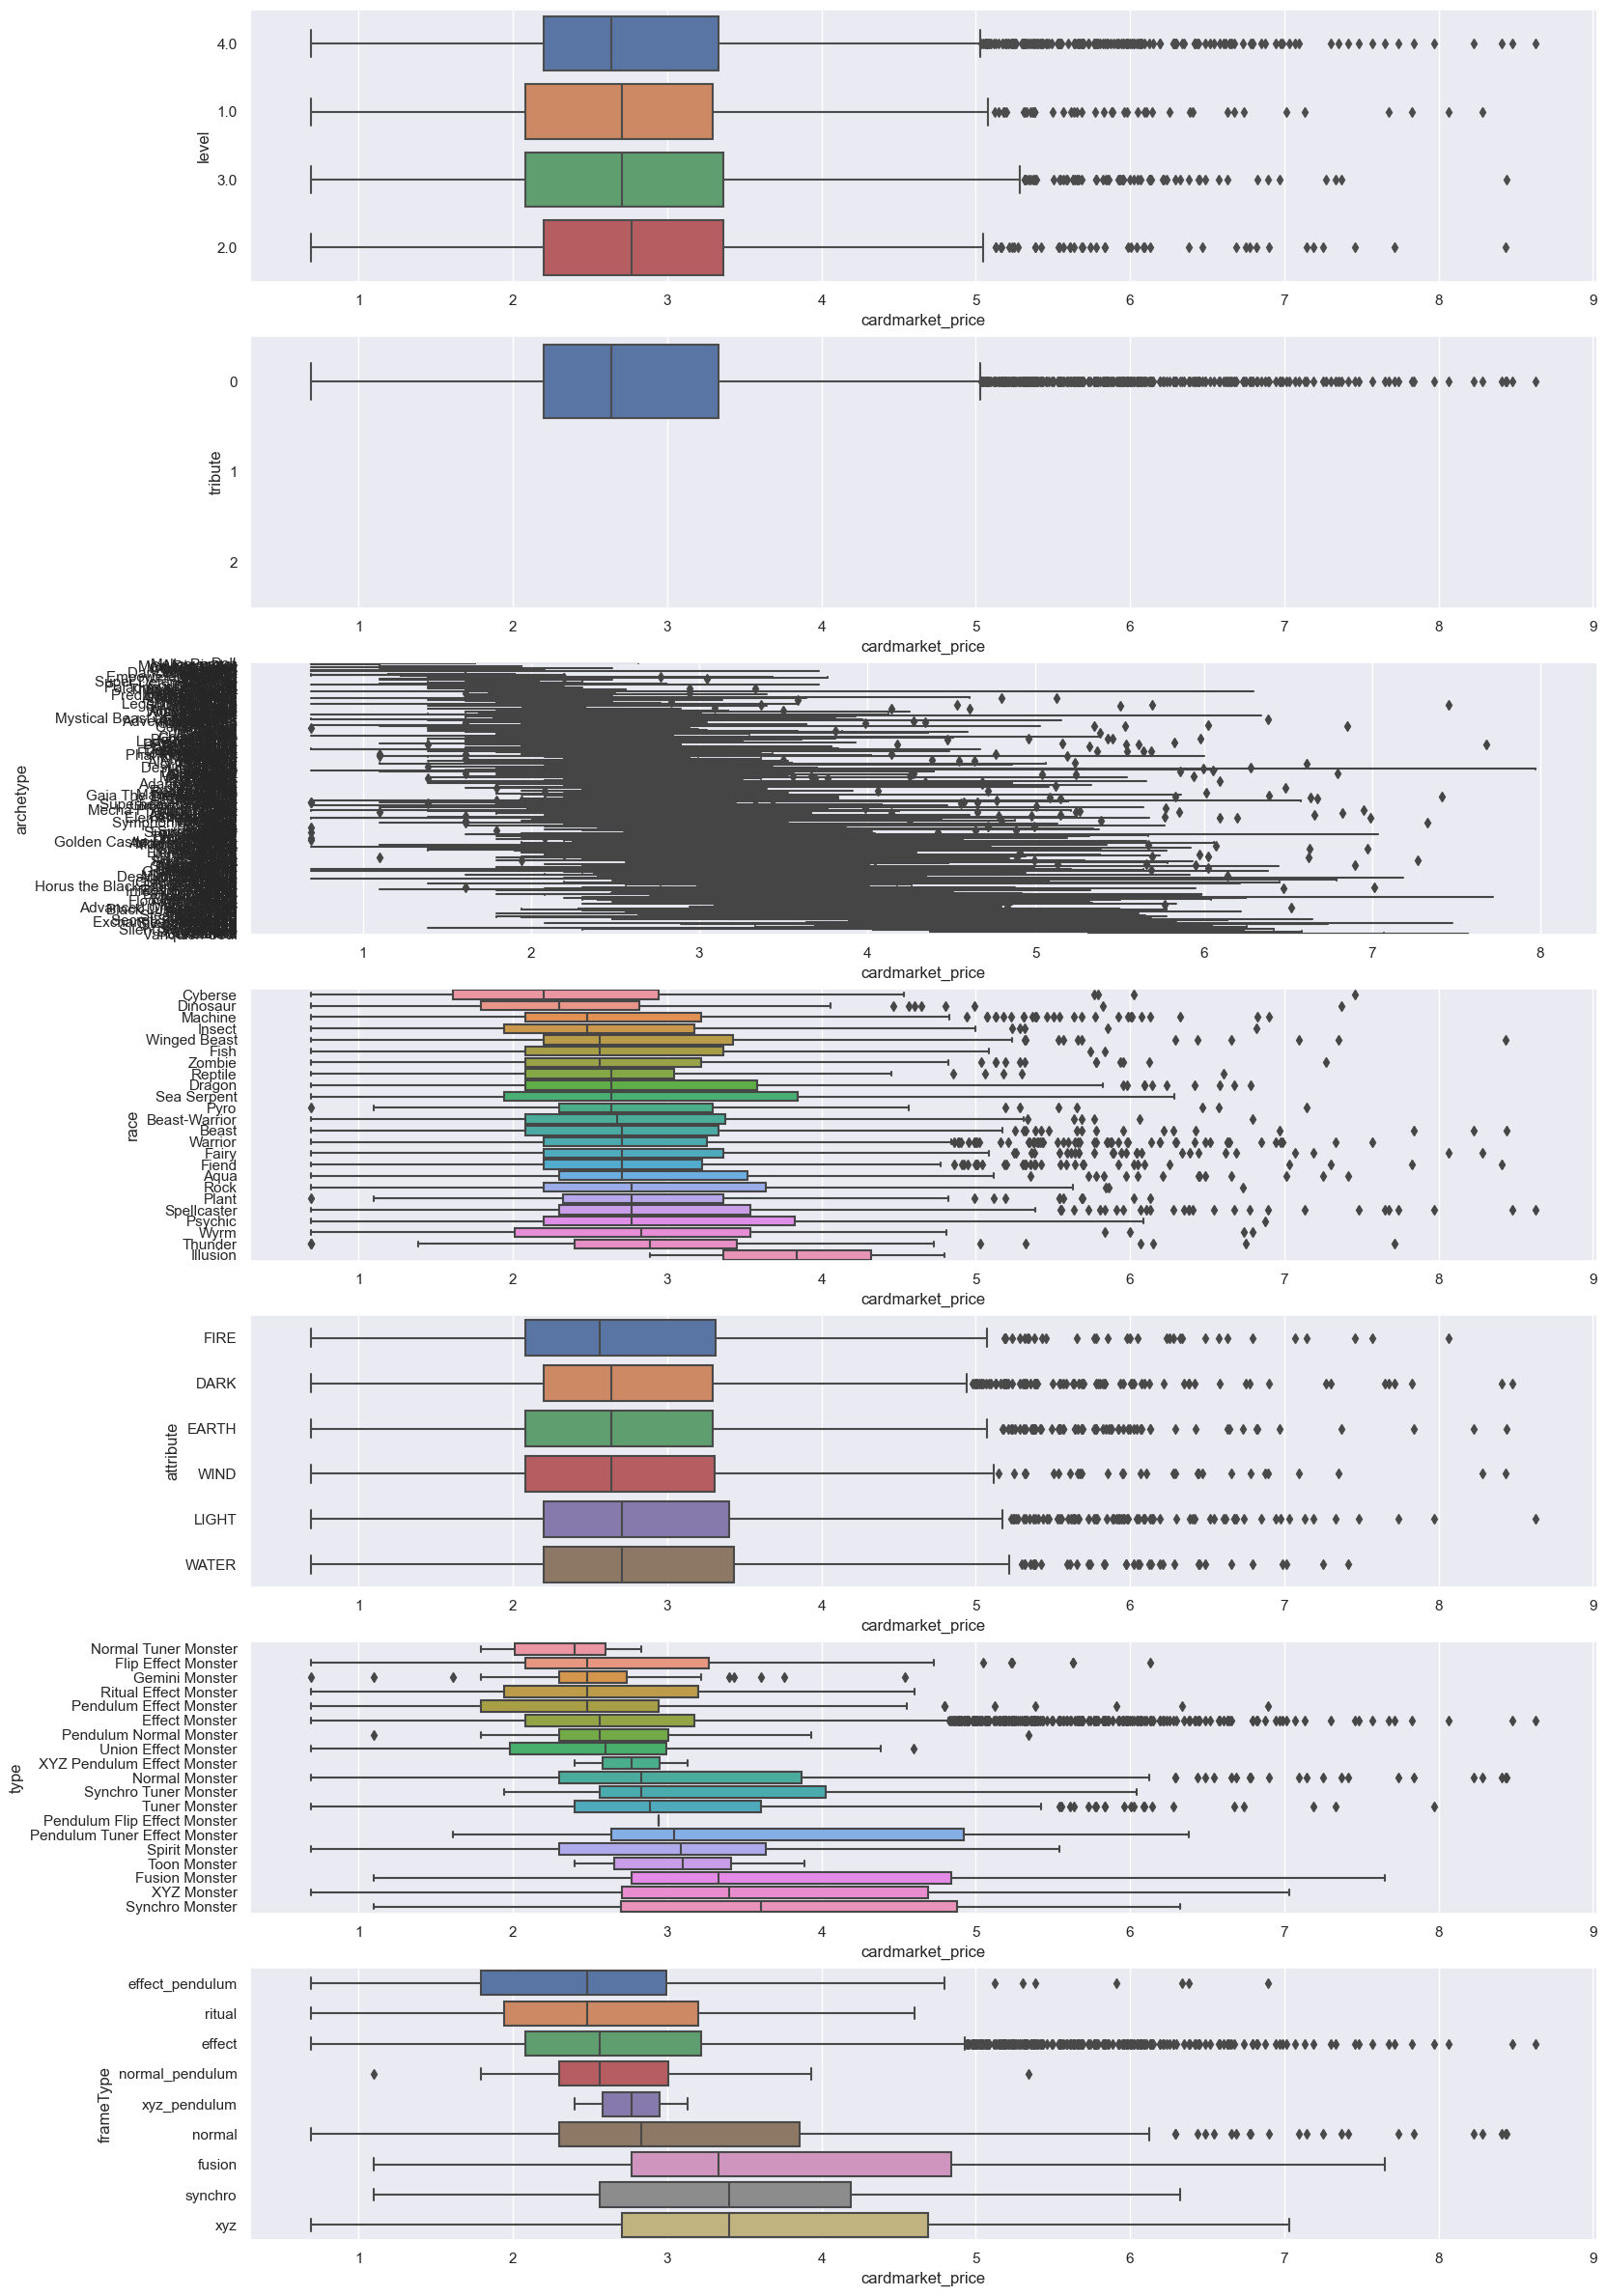

In [29]:
#yugioh_data.info()
#yugioh_data.head()

f, axes = plt.subplots(len(categories)-1, 1, figsize=(18, 30))
count = 0
for var in categories[:-1]:
    sb.boxplot(data = yugioh_data_categorical, x="cardmarket_price", y=var, orient = 'h', ax = axes[count], order = yugioh_data_categorical.groupby(var)['cardmarket_price'].median().sort_values().index)
    count+=1


# EDA of Categorical Value of Sacrifice
Using the following variables to predict `tribute`: `atk`, `def`, `atk+def`, `atkSq`, `defSq`, `atkSq+defSq`

In Yu-Gi-Oh, when a monster is level 5 or above it would require sacrifice to summon it. Thus by using the folling variable, we would be checking if it is possible to predict if a monster requires sacrifice to summon.

In [35]:
categories = ['atk','def','atk+def','atkSq','defSq','atkSq+defSq','tribute']
yugioh_data_categorical = yugioh_data[categories]
#yugioh_data_categorical = yugioh_data_categorical[(yugioh_data_categorical['frameType'] == "normal")]

print(yugioh_data_categorical['tribute'].value_counts())

tribute
0    4689
2    1629
1    1189
Name: count, dtype: int64


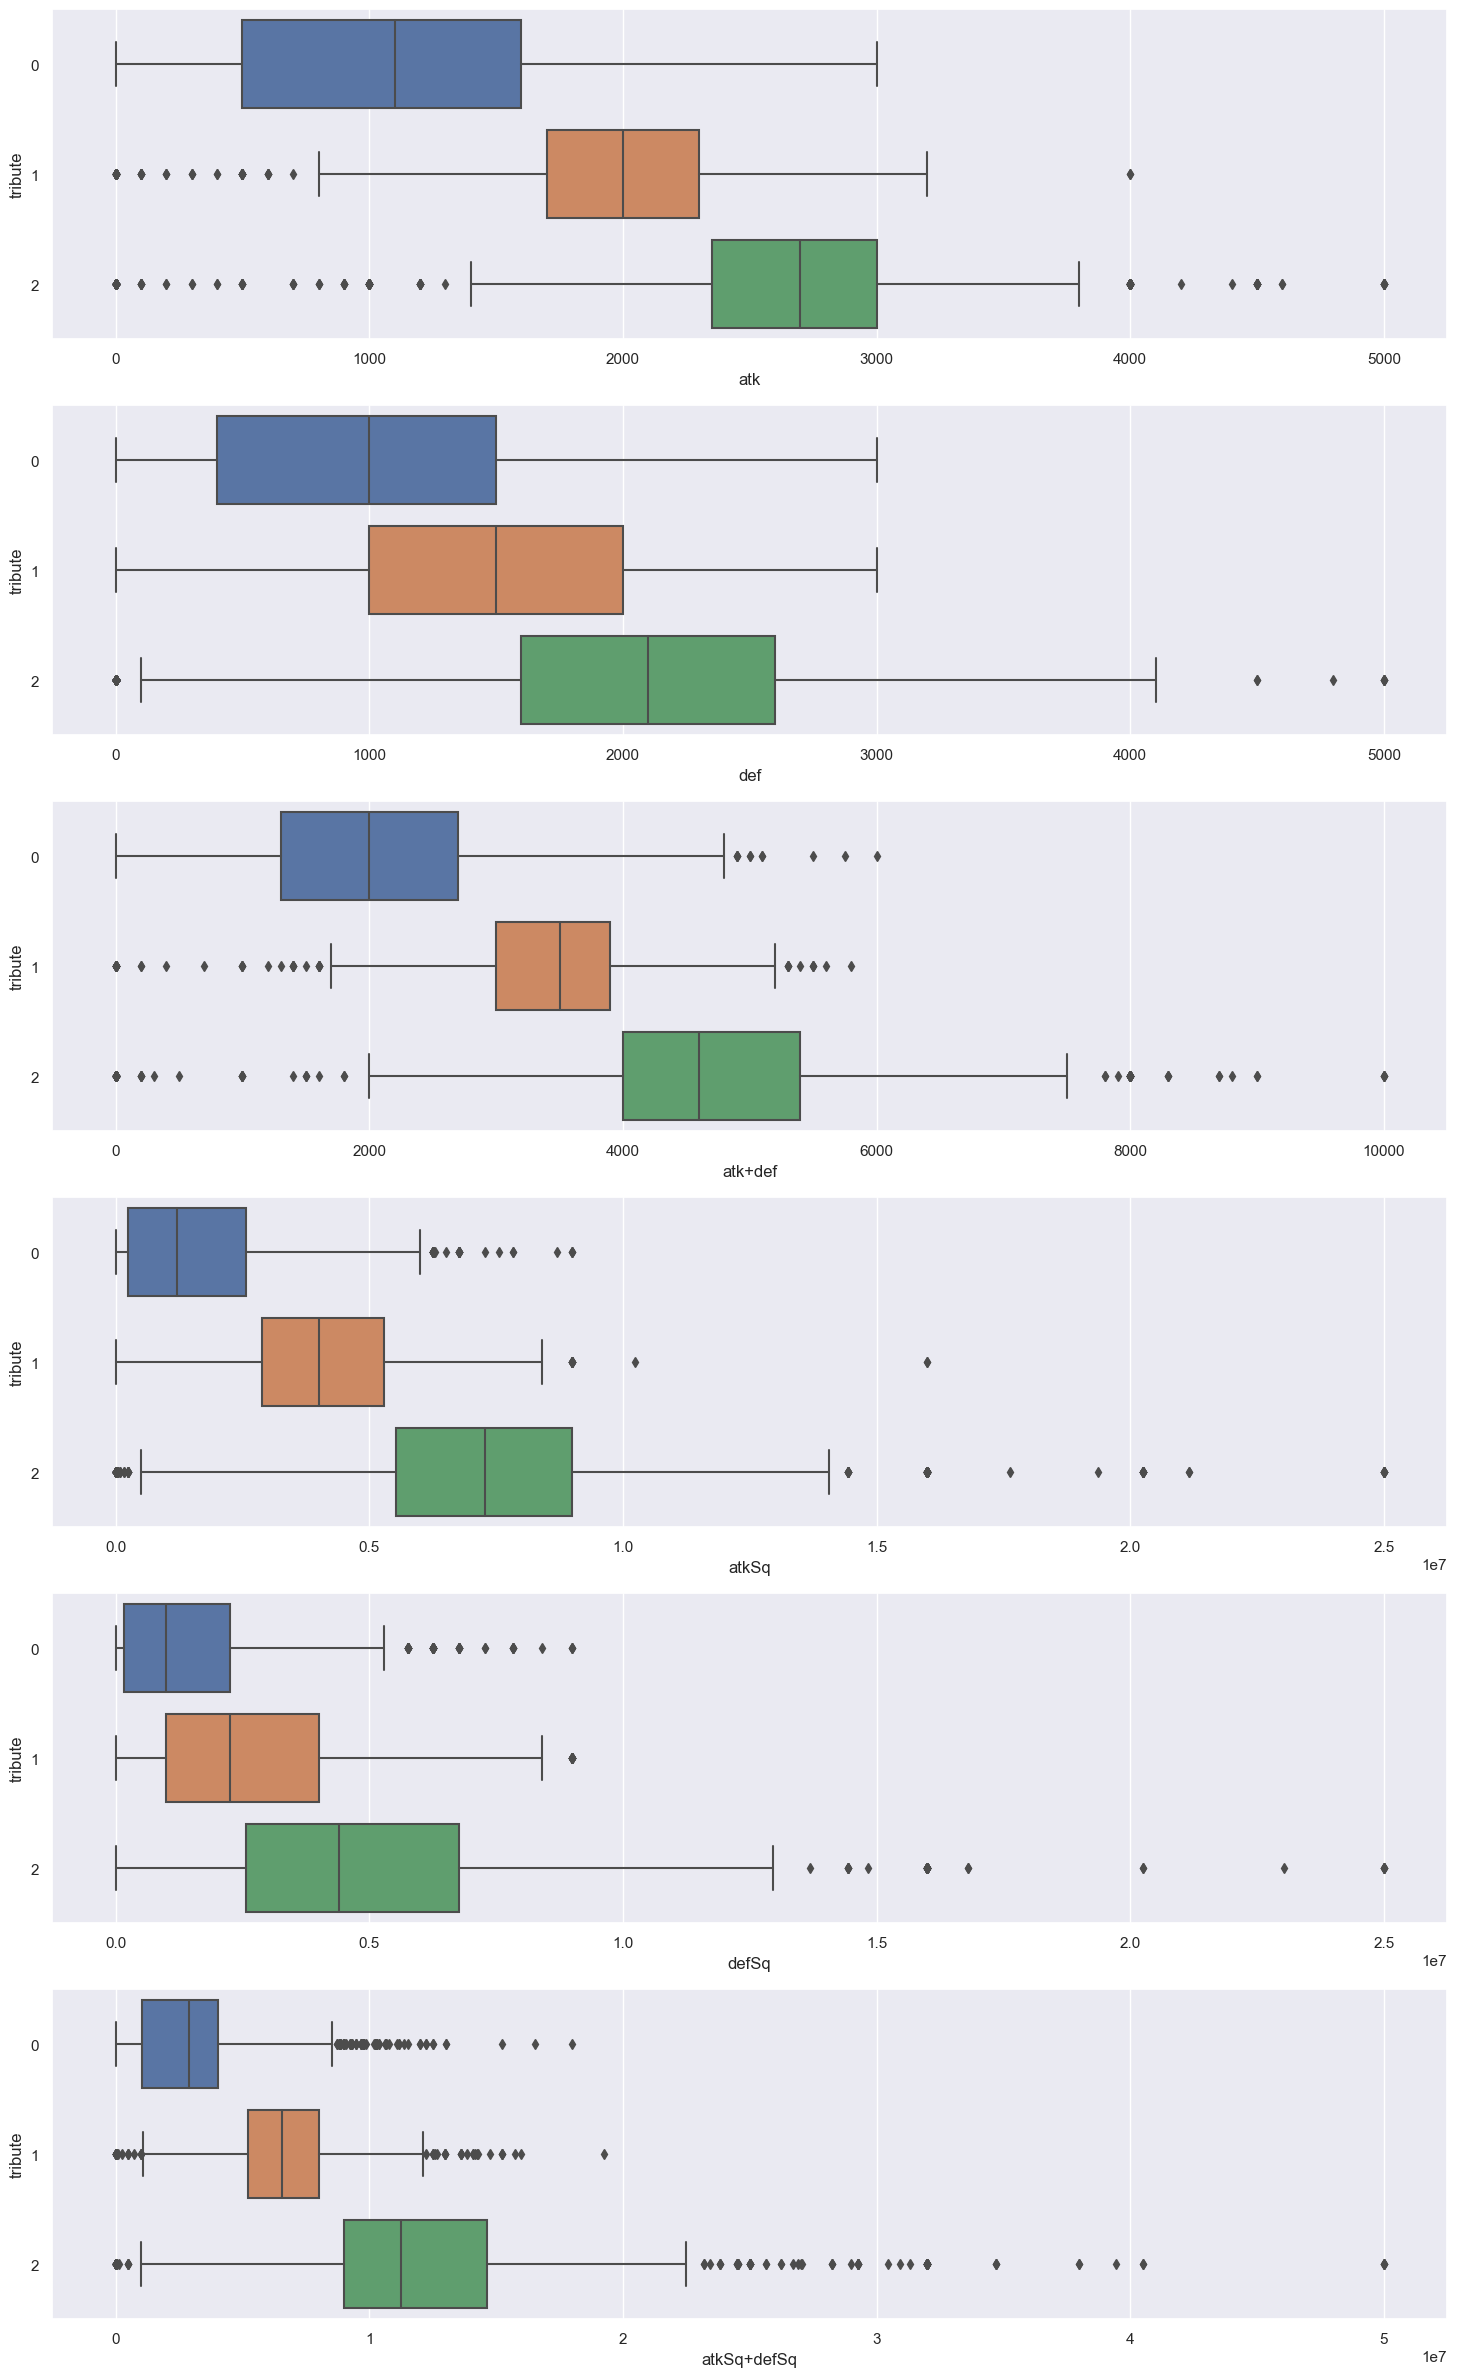

In [37]:
#yugioh_data.info()
#yugioh_data.head()

f, axes = plt.subplots(len(categories)-1, 1, figsize=(18, 30))
count = 0
for var in categories[:-1]:
    sb.boxplot(data = yugioh_data_categorical, x=var, y='tribute', orient = 'h', ax = axes[count], order = yugioh_data_categorical.groupby('tribute')[var].median().sort_values().index)
    count+=1
